In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
print(torch.__version__)
import time
import matplotlib.pyplot as plt
import scipy.io
from utilities3 import *

import operator
from functools import reduce
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage.filters import gaussian_filter

torch.manual_seed(0)
np.random.seed(0)

mse_train = []
l2_test = []


2.0.0+cu117


/tmp/ipykernel_62804/3251764722.py:15: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
dx = 0.01
dz = 0.01


dx_kernel = torch.tensor([[0, 0, 0],
                        [-1/2/dx, 0, 1/2/dx],
                        [0, 0, 0]], dtype=torch.float, requires_grad=False).view(1, 1, 3, 3)

dz_kernel = torch.tensor([[0, -1/2/dz, 0],
                        [0, 0, 0],
                        [0, 1/2/dz, 0]], dtype=torch.float, requires_grad=False).view(1, 1, 3, 3)

def conv_dx(x, dx_kernel):
        
    batch_size, size_ns,  size_z, size_x = x.shape[0], x.shape[1], x.shape[2], x.shape[3]
    dx_kernel = dx_kernel.repeat(1, 1, 1, 1).to(device)
    y_dx = torch.zeros(batch_size, size_ns, size_z, size_x, device=device)
    for isou in range(size_ns):
        y_dx[:,isou:isou+1,:,:] = F.conv2d(x[:,isou:isou+1,:,:], dx_kernel, stride=1, padding=1,)    
    return y_dx

def conv_dz(x, dz_kernel):
        
    batch_size, size_ns,  size_z, size_x = x.shape[0], x.shape[1], x.shape[2], x.shape[3]
    dz_kernel = dz_kernel.repeat(1, 1, 1, 1).to(device)
    y_dz = torch.zeros(batch_size, size_ns, size_z, size_x, device=device)
    for isou in range(size_ns):
        y_dz[:,isou:isou+1,:,:] = F.conv2d(x[:,isou:isou+1,:,:], dz_kernel, stride=1, padding=1,)    
    return y_dz

In [3]:
ns_num = 20
#Complex multiplication
def compl_mul3d(a, b):
    # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
    op = partial(torch.einsum, "bixyz,ioxyz->boxyz")
    return torch.stack([
        op(a[..., 0], b[..., 0]) - op(a[..., 1], b[..., 1]),
        op(a[..., 1], b[..., 0]) + op(a[..., 0], b[..., 1])
    ], dim=-1)

################################################################
###################### 3d fourier layers #######################
################################################################

class SpectralConv3d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d_fast, self).__init__()

        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, 2))
        print("self.weights1:",self.weights1.shape)
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, 2))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, 2))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, 2))

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        #x_ft = torch.rfft(x,signal_ndim=3, normalized=True, onesided=True)
        x_ft = torch.stack((torch.fft.fftn(x,dim=(-3,-2,-1), norm="forward").real, torch.fft.fftn(x,dim=(-3,-2,-1), norm="forward").imag),dim=-1)
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.in_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, 2, device=x.device)       
        print("out_ft:",out_ft.shape)
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        #x = torch.irfft(out_ft, 3, normalized=True, onesided=True, signal_sizes=(x.size(-3), x.size(-2), x.size(-1)))
        out_ft = torch.complex(out_ft[:,:,:,:,:,0],out_ft[:,:,:,:,:,1]).squeeze(0)
        x = torch.fft.ifftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)),dim=(-3,-2,-1), norm="forward").real

        return x

In [4]:
#Complex multiplication
def compl_mul3d(a, b):
    # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
    op = partial(torch.einsum, "bixyz,ioxyz->boxyz")
    return torch.stack([
        op(a[..., 0], b[..., 0]) - op(a[..., 1], b[..., 1]),
        op(a[..., 1], b[..., 0]) + op(a[..., 0], b[..., 1])
    ], dim=-1)

################################################################
###################### 3d fourier layers #######################
################################################################

class SpectralConv3d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d_fast, self).__init__()

        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, 2))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, 2))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, 2))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, 2))

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        #x_ft = torch.rfft(x,signal_ndim=3, normalized=True, onesided=True)
        x_ft = torch.stack((torch.fft.fftn(x,dim=(-3,-2,-1), norm="forward").real, torch.fft.fftn(x,dim=(-3,-2,-1), norm="forward").imag),dim=-1)
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.in_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, 2, device=x.device)       
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        #x = torch.irfft(out_ft, 3, normalized=True, onesided=True, signal_sizes=(x.size(-3), x.size(-2), x.size(-1)))
        out_ft = torch.complex(out_ft[:,:,:,:,:,0],out_ft[:,:,:,:,:,1]).squeeze(0)
        x = torch.fft.ifftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)),dim=(-3,-2,-1), norm="forward").real

        return x

class SimpleBlock3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width):
        super(SimpleBlock3d, self).__init__()

        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.fc0 = nn.Linear(ns_num, self.width)
        # input channel is 12: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t)

        self.conv0 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv3 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv4 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv5 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv6 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)

        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.w4 = nn.Conv1d(self.width, self.width, 1)
        self.w5 = nn.Conv1d(self.width, self.width, 1)
        self.w6 = nn.Conv1d(self.width, self.width, 1)

        self.bn0 = torch.nn.BatchNorm3d(self.width)
        self.bn1 = torch.nn.BatchNorm3d(self.width)
        self.bn2 = torch.nn.BatchNorm3d(self.width)
        self.bn3 = torch.nn.BatchNorm3d(self.width)
        self.bn4 = torch.nn.BatchNorm3d(self.width)
        self.bn5 = torch.nn.BatchNorm3d(self.width)
        self.bn6 = torch.nn.BatchNorm3d(self.width)

        
        num_neuron = 128
        self.fc1 = nn.Linear(self.width, num_neuron)
        self.fc2 = nn.Linear(num_neuron, num_neuron)

        self.fc3 = nn.Linear(num_neuron, 1)

    def forward(self, x, y):
        
        #batchsize, size_ns, size_z, size_x, size_c
        batchsize, size_ns, size_z, size_x, size_c = x.shape[0], x.shape[1], x.shape[2], x.shape[3], x.shape[4]
        
        T0 = x[:,:,:,:,10]
        T0_dx = conv_dx(T0, dx_kernel)## batchsize, size_ns, size_z, size_x
        T0_dz = conv_dz(T0, dz_kernel)## batchsize, size_ns, size_z, size_x
        
        slope = 0.1
        x = self.fc0(x) #batchsize, size_ns, size_z, size_x, size_c
        x = x.permute(0, 4, 1, 2, 3) #batchsize, size_c, size_ns, size_z, size_x
        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_ns, size_z, size_x)
        x = self.bn0(x1 + x2)
        x = F.leaky_relu(x,slope)       
        
        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_ns, size_z, size_x)
        x = self.bn1(x1 + x2)
        x = F.leaky_relu(x,slope)       
        
        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_ns, size_z, size_x)
        x = self.bn2(x1 + x2)
        x = F.leaky_relu(x,slope)     
        
        x1 = self.conv3(x)
        x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_ns, size_z, size_x)
        x = self.bn3(x1 + x2)
        x = F.leaky_relu(x,slope)    
        
        x1 = self.conv4(x)
        x2 = self.w4(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_ns, size_z, size_x)
        x = self.bn4(x1 + x2)
        x = F.leaky_relu(x,slope)       
      
        
        x = x.permute(0, 2, 3, 4, 1)
        
        x = self.fc1(x)#batchsize, size_ns, size_z, size_x, size_c
        x = F.leaky_relu(x,slope)
        x = self.fc2(x)
        x = F.leaky_relu(x,slope)        
        x = self.fc2(x)
        x = F.leaky_relu(x,slope)
        x = self.fc2(x)
        x = F.leaky_relu(x,slope)
        x = self.fc2(x)
        x = F.leaky_relu(x,slope)
        x = self.fc2(x)
        x = F.leaky_relu(x,slope)
        
        x = self.fc3(x).view(batchsize, size_ns, size_z, size_x) #batchsize, size_ns, size_z, size_x
        mask = torch.where(T0<0.01,T0,torch.ones(batchsize, size_ns, size_z, size_x,device=device))
        mask[:,:,0:2,:] = 0
        x = x*mask
        
        tau_dx = conv_dx(x, dx_kernel)
        tau_dz = conv_dz(x, dz_kernel)
        
        loss = (tau_dx + T0_dx)**2 + (tau_dz + T0_dz)**2 - y

        return x, loss

class Net3d(nn.Module):
    def __init__(self, modes, width):
        super(Net3d, self).__init__()
        
        self.conv1 = SimpleBlock3d(modes, modes, modes, width)

    def forward(self, x, y):
        x = self.conv1(x, y)
        return x

    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c  

In [5]:
modes = 8
width = 20

epochs = 8000 #8000 for curvelet
learning_rate = 0.0025 #0.0025 for curvelet
scheduler_step = epochs//4
scheduler_gamma = 0.5
print(epochs, learning_rate, scheduler_step, scheduler_gamma)

path = 'pifnoeikonal_layer'
path_model = 'model_eikonal/'+path

runtime = np.zeros(2, )
t1 = time.time()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Computational model parameters
zmin = 0.;  deltaz = 0.01; zmax = 0.7;
xmin = 0.;  deltax = 0.01; xmax = 0.7;
train_vel = []
train_T_data = []
train_T0_data = []
# Loading the velocity model
for i in range(1, 51):

    vel = np.load('./Model/model3/model_%d.npy'%(i))
    vels = gaussian_filter(vel, sigma=1)
    
    T0 = np.load('./Model/model3/T0_data%d.npy'%(i))
    T = np.load('./Model/model3/T_data%d.npy'%(i))
    train_vel.append(vels)
    train_T0_data.append(T0)
    train_T_data.append(T)
    
train_T_data = torch.Tensor(np.array(train_T_data)).permute(0,3,1,2)
train_T0_data = torch.Tensor(np.array(train_T0_data)).permute(0,3,1,2)
train_tau = train_T_data - train_T0_data
nv, ns, nz, nx = train_T_data.shape[0], train_T_data.shape[1], train_T_data.shape[2], train_T_data.shape[3]
train_vel = torch.Tensor(np.array(train_vel)).repeat(ns,1,1,1).permute(1,0,2,3)
train_right = 1/train_vel/train_vel
train_T0 =  torch.cat((train_right.view(nv, ns, nz, nx, 1).repeat([1,1,1,1,ns]), train_T0_data.view(nv, ns, nz, nx, 1).repeat([1,1,1,1,ns])), dim=-1)


8000 0.0025 2000 0.5


torch.Size([50, 10, 70, 70])


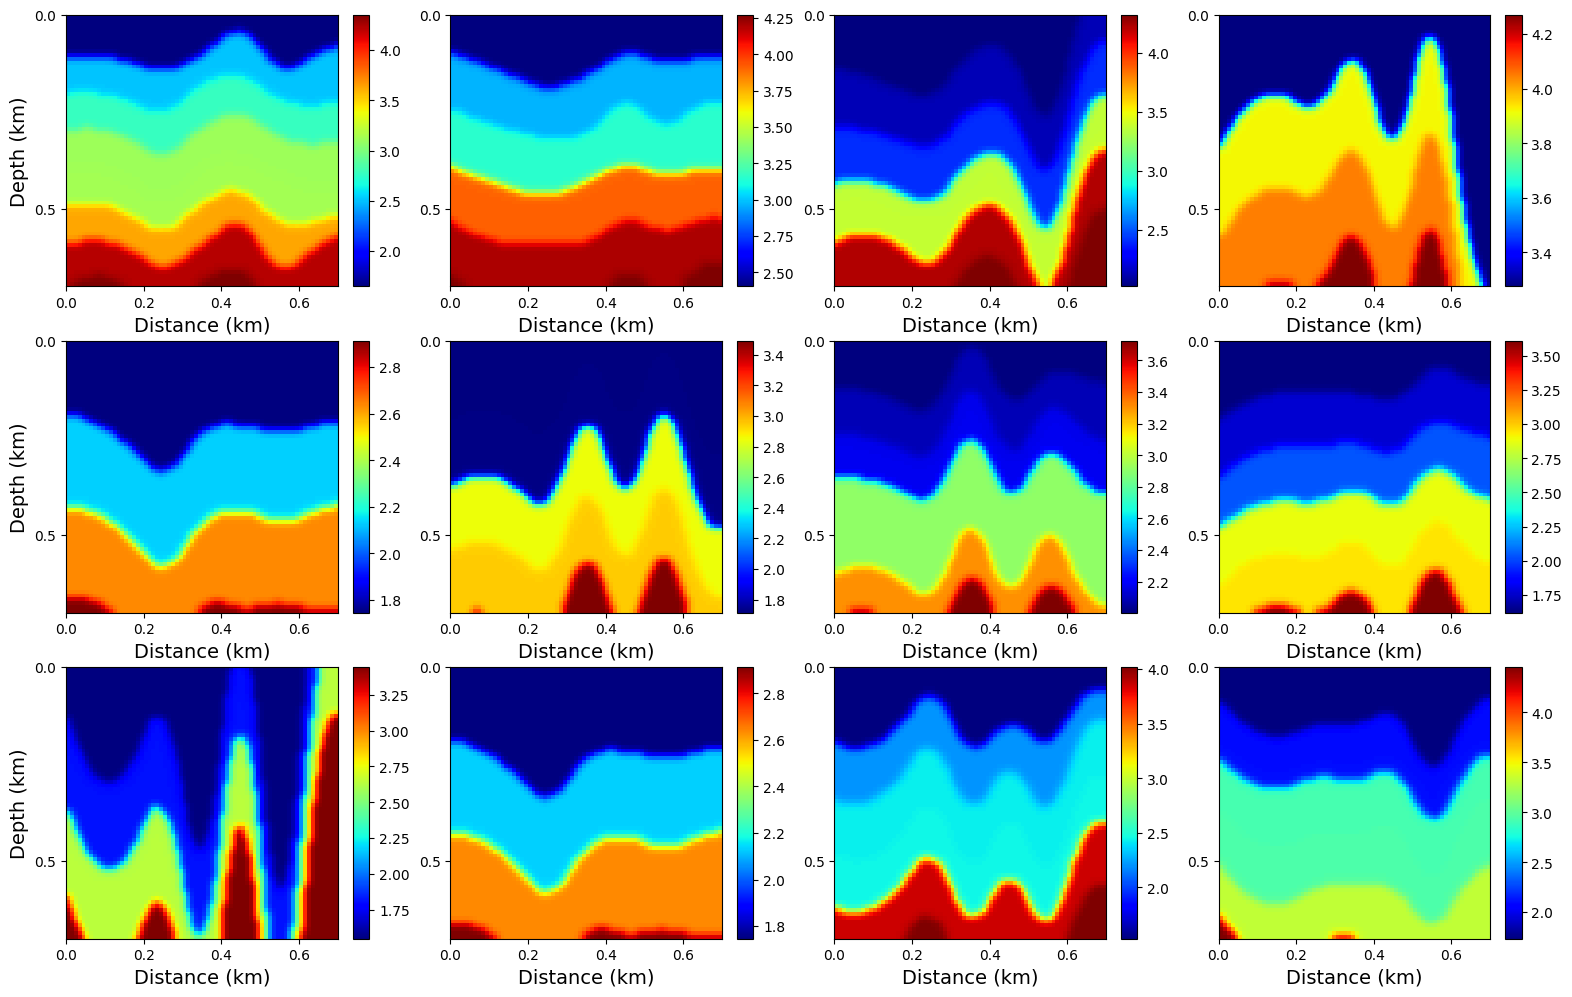

In [6]:
print(train_T_data.shape)

isou = 5
iv1 = 20
iv2 = 30
iv3 = 39
plt.style.use('default')

plt.figure(figsize=(19,12))

plt.subplot(3,4,1)
ax = plt.gca()
im = ax.imshow(train_vel[10,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)
plt.subplot(3,4,2)
ax = plt.gca()
im = ax.imshow(train_vel[20,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Distance (km)', fontsize=14)
plt.xticks(fontsize=10)

ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
plt.subplot(3,4,3)
ax = plt.gca()
im = ax.imshow(train_vel[30,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")


plt.xlabel('Distance (km)', fontsize=14)
plt.xticks(fontsize=10)

ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
plt.subplot(3,4,4)
ax = plt.gca()
im = ax.imshow(train_vel[40,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")


plt.xlabel('Distance (km)', fontsize=14)
plt.xticks(fontsize=10)

ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,5)
ax = plt.gca()
im = ax.imshow(train_vel[12,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Distance (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)
plt.subplot(3,4,6)
ax = plt.gca()
im = ax.imshow(train_vel[15,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Distance (km)', fontsize=14)
plt.xticks(fontsize=10)

ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,7)
ax = plt.gca()
im = ax.imshow(train_vel[24,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")

plt.xlabel('Distance (km)', fontsize=14)
plt.xticks(fontsize=10)

ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
plt.subplot(3,4,8)
ax = plt.gca()
im = ax.imshow(train_vel[26,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")

plt.xlabel('Distance (km)', fontsize=14)
plt.xticks(fontsize=10)

ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,9)
ax = plt.gca()
im = ax.imshow(train_vel[34,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Distance (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)
plt.subplot(3,4,10)
ax = plt.gca()
im = ax.imshow(train_vel[12,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Distance (km)', fontsize=14)
plt.xticks(fontsize=10)

ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,11)
ax = plt.gca()
im = ax.imshow(train_vel[22,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")


plt.xlabel('Distance (km)', fontsize=14)
plt.xticks(fontsize=10)

ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
plt.subplot(3,4,12)
ax = plt.gca()
im = ax.imshow(train_vel[32,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")


plt.xlabel('Distance (km)', fontsize=14)
plt.xticks(fontsize=10)

ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
plt.savefig('./Fig/CurveVel.jpeg',dpi=400)

In [7]:
batch_size = nv
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_T0, train_right), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_T0, train_right, train_tau), batch_size=batch_size, shuffle=False)
print("train_T0:",train_T0.shape)
t2 = time.time()

print('preprocessing finished, time used:', t2-t1)

model = Net3d(modes, width).cuda()

#model = torch.load(path_model)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1*1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

myloss = LpLoss(size_average=False)
mae = nn.L1Loss( reduction='sum')

Huber = nn.HuberLoss( reduction='sum')

train_T0: torch.Size([50, 10, 70, 70, 20])
preprocessing finished, time used: 3.0645759105682373


epoch: 0 MSE loss: 48736.4453125 Accuracy(%): 10.199546813964844


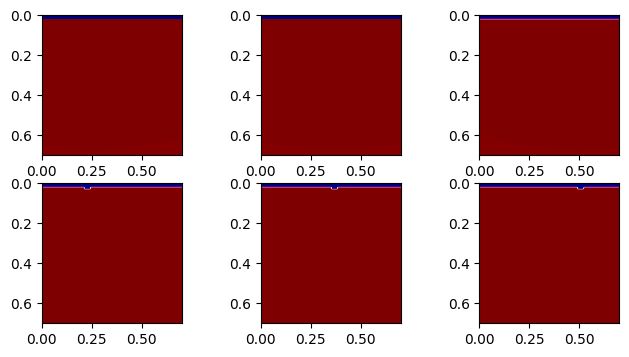

epoch: 10 MSE loss: 38488.84375 Accuracy(%): 15.974140167236328


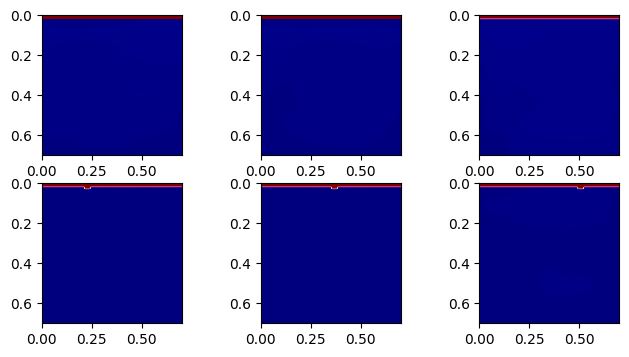

epoch: 20 MSE loss: 14919.5703125 Accuracy(%): 3.162021636962886


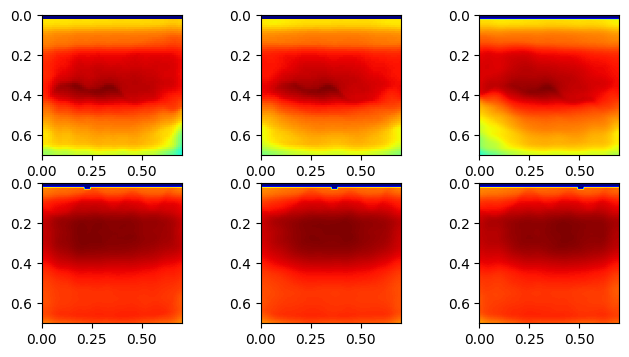

epoch: 30 MSE loss: 6918.1259765625 Accuracy(%): 2.5740623474121094


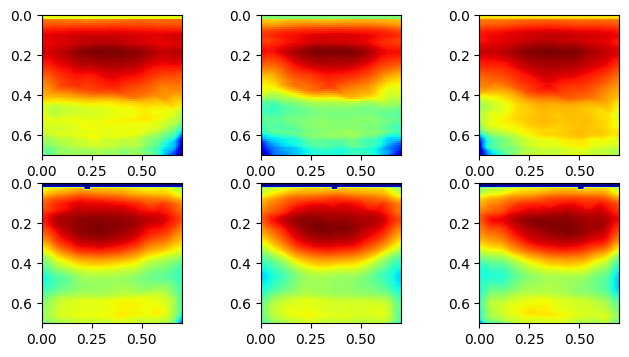

epoch: 40 MSE loss: 3921.1328125 Accuracy(%): 25.050683021545407


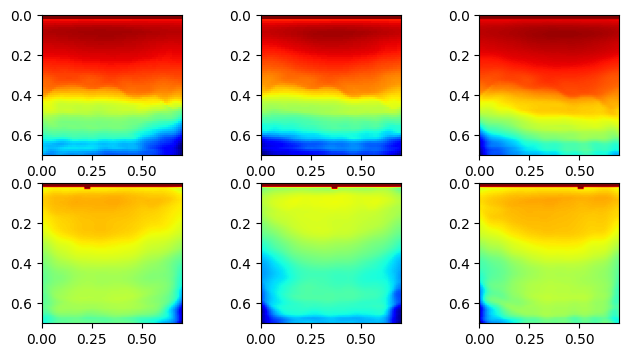

epoch: 50 MSE loss: 2778.1455078125 Accuracy(%): 42.63422966003419


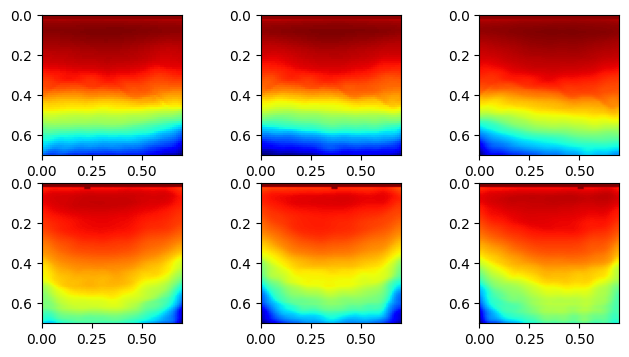

epoch: 60 MSE loss: 2233.97216796875 Accuracy(%): 62.55342483520507


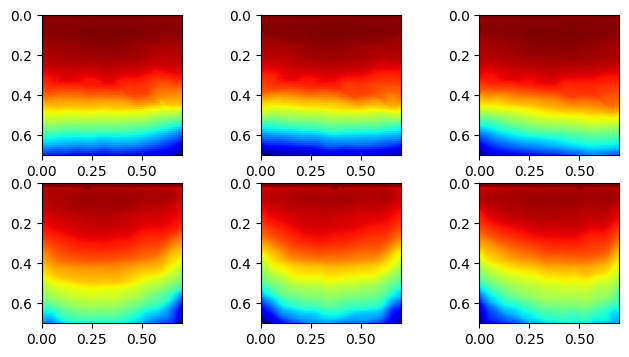

epoch: 70 MSE loss: 1907.0740966796875 Accuracy(%): 73.77862453460693


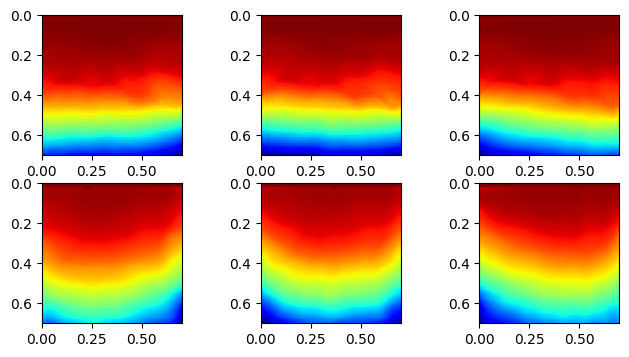

epoch: 80 MSE loss: 1683.015625 Accuracy(%): 78.362135887146


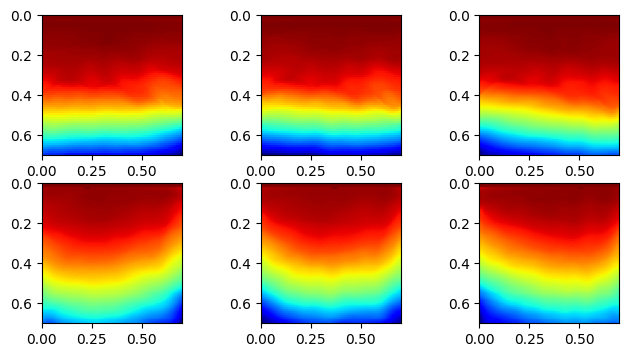

epoch: 90 MSE loss: 1509.582275390625 Accuracy(%): 79.66940879821777


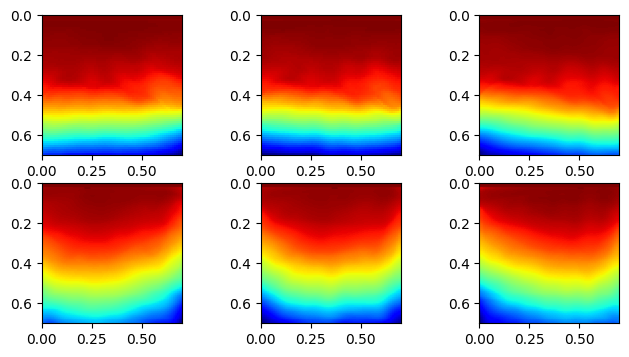

epoch: 100 MSE loss: 1368.709228515625 Accuracy(%): 80.18464088439941


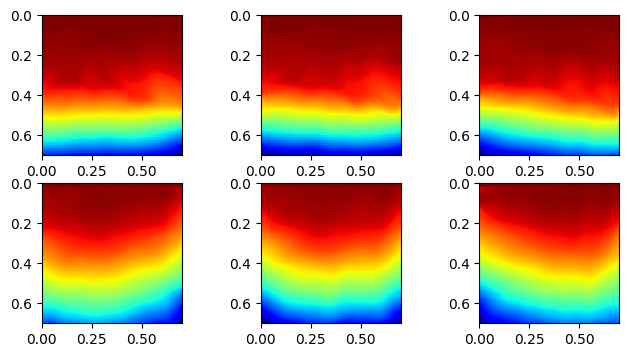

epoch: 110 MSE loss: 1250.2283935546875 Accuracy(%): 80.82200288772583


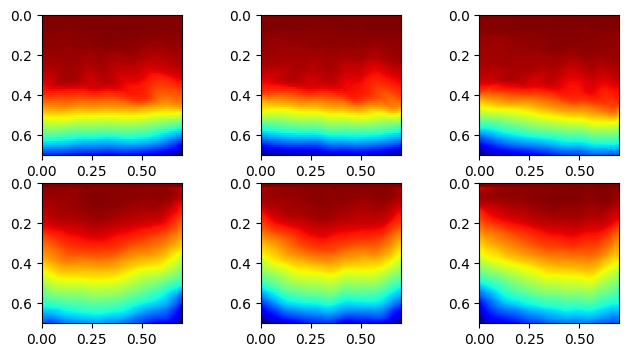

epoch: 120 MSE loss: 1148.946044921875 Accuracy(%): 81.69538617134094


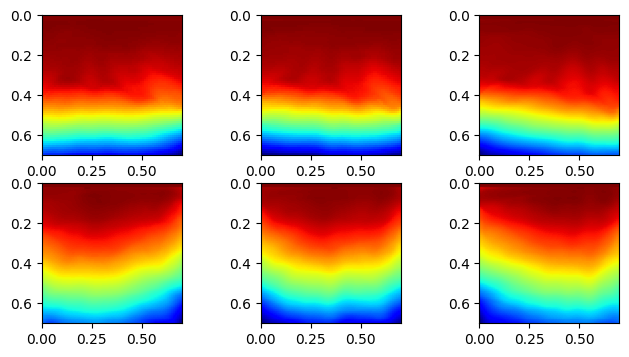

epoch: 130 MSE loss: 1061.537353515625 Accuracy(%): 81.97357416152954


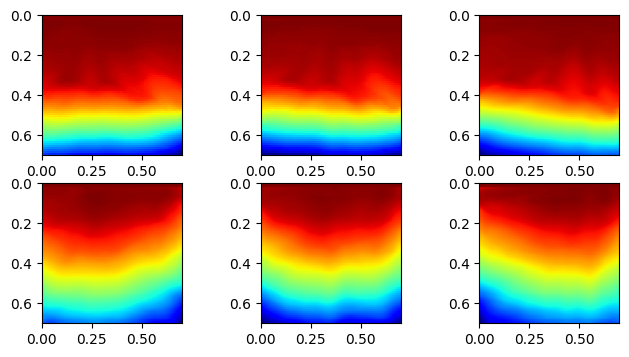

epoch: 140 MSE loss: 985.5858154296875 Accuracy(%): 81.95672750473022


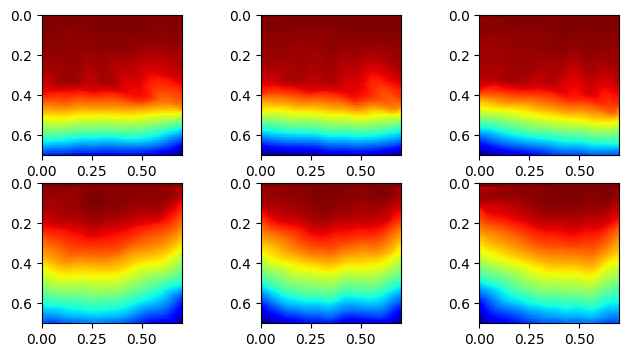

epoch: 150 MSE loss: 919.10693359375 Accuracy(%): 82.69072771072388


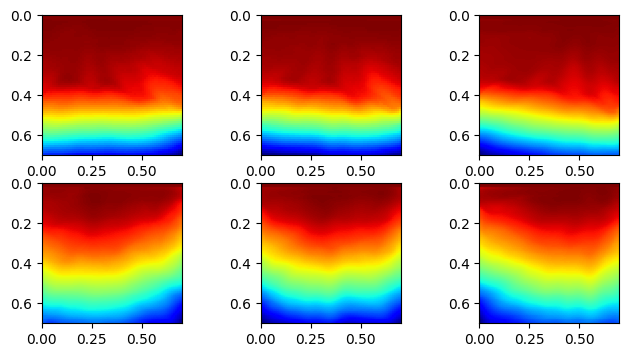

epoch: 160 MSE loss: 860.6099853515625 Accuracy(%): 83.27341079711914


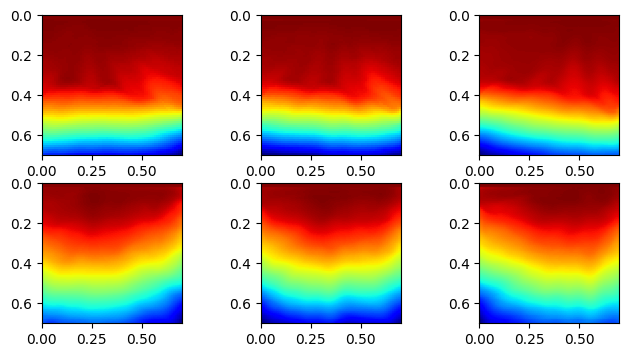

epoch: 170 MSE loss: 808.8938598632812 Accuracy(%): 83.44550490379333


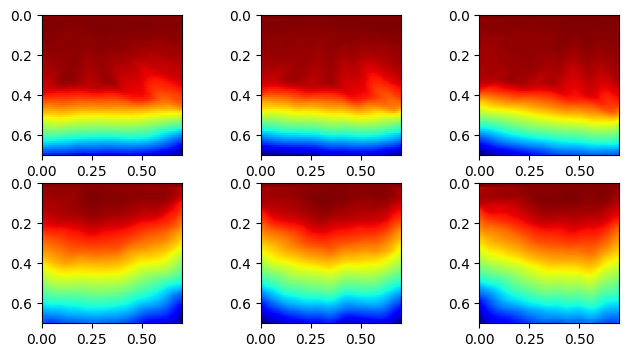

epoch: 180 MSE loss: 763.1777954101562 Accuracy(%): 83.70599150657654


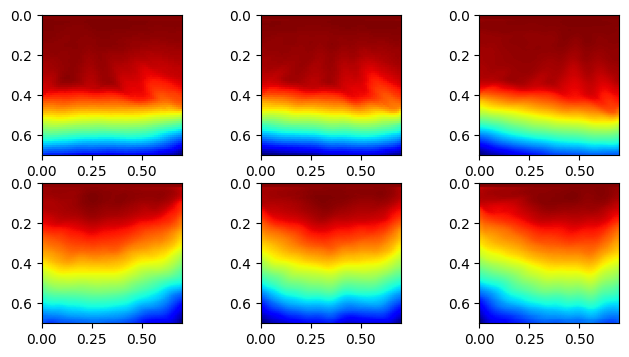

epoch: 190 MSE loss: 722.2678833007812 Accuracy(%): 83.73965740203857


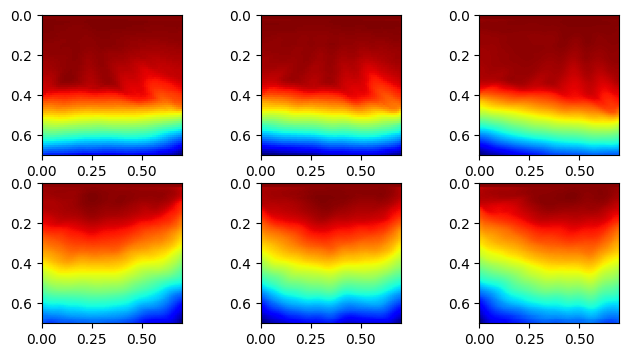

epoch: 200 MSE loss: 685.4656372070312 Accuracy(%): 83.41838479042053


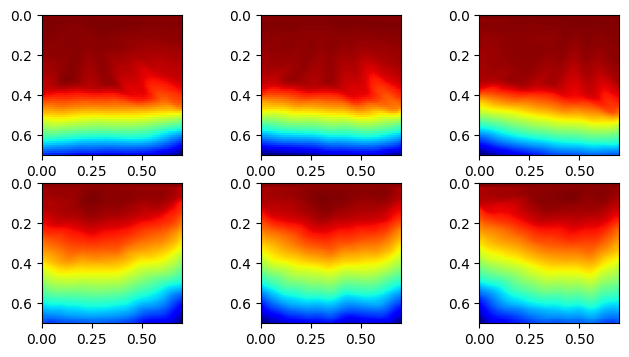

epoch: 210 MSE loss: 652.1105346679688 Accuracy(%): 83.93354415893555


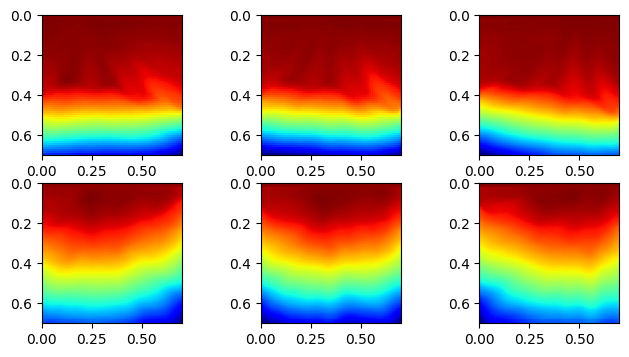

epoch: 220 MSE loss: 621.788330078125 Accuracy(%): 84.2853331565857


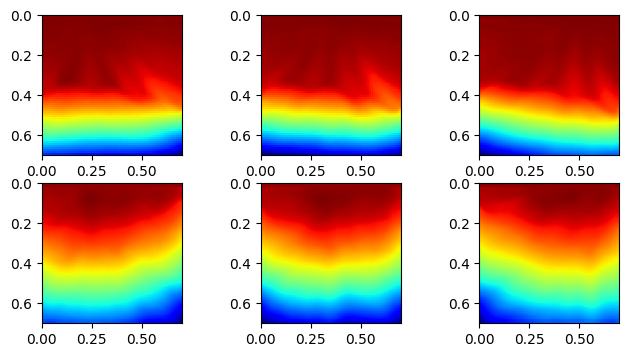

epoch: 230 MSE loss: 594.154541015625 Accuracy(%): 84.07419323921204


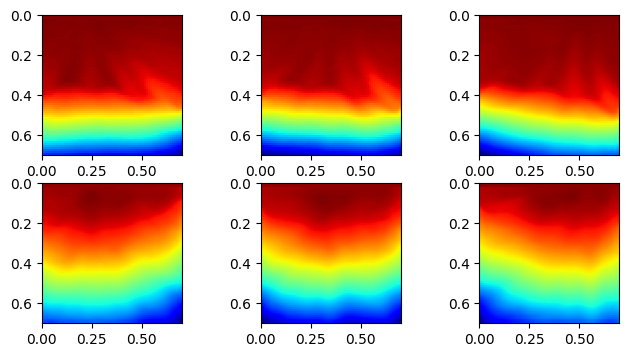

epoch: 240 MSE loss: 612.79736328125 Accuracy(%): 84.22312021255493


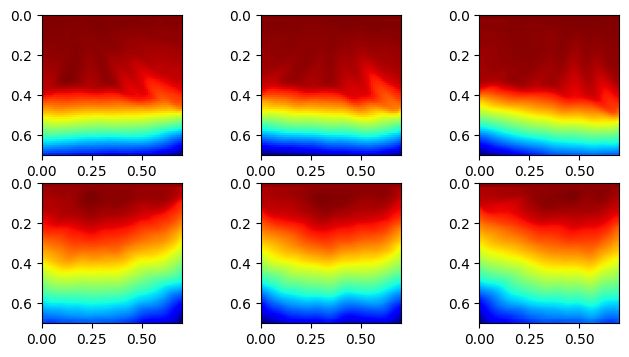

epoch: 250 MSE loss: 571.5621337890625 Accuracy(%): 84.19849157333374


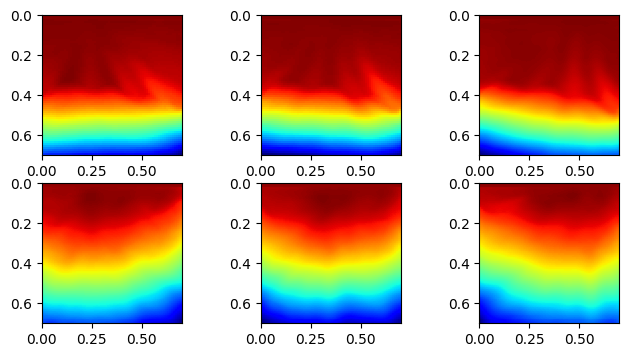

epoch: 260 MSE loss: 525.0015869140625 Accuracy(%): 84.01708364486694


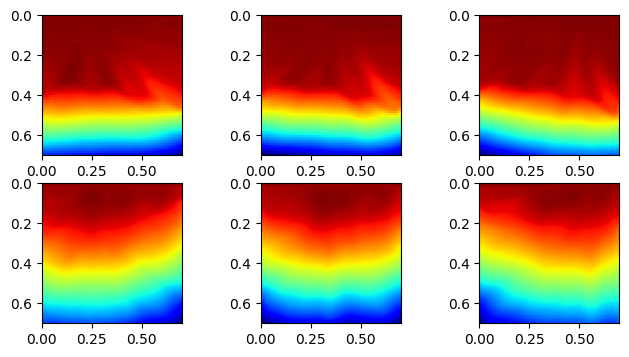

epoch: 270 MSE loss: 511.10772705078125 Accuracy(%): 84.65463995933533


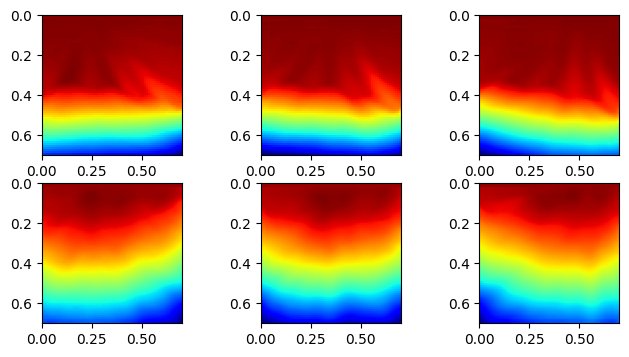

epoch: 280 MSE loss: 487.9662780761719 Accuracy(%): 85.26650190353394


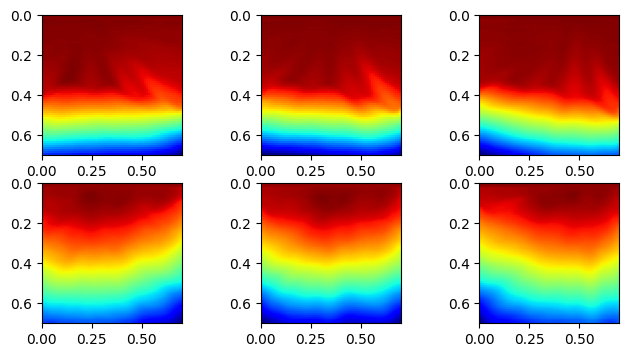

epoch: 290 MSE loss: 470.02545166015625 Accuracy(%): 85.46244859695435


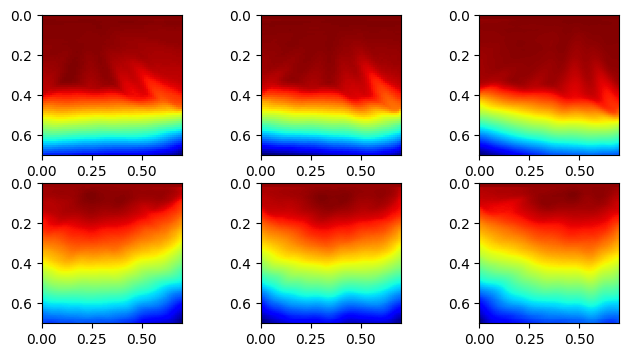

epoch: 300 MSE loss: 484.28265380859375 Accuracy(%): 85.56525230407715


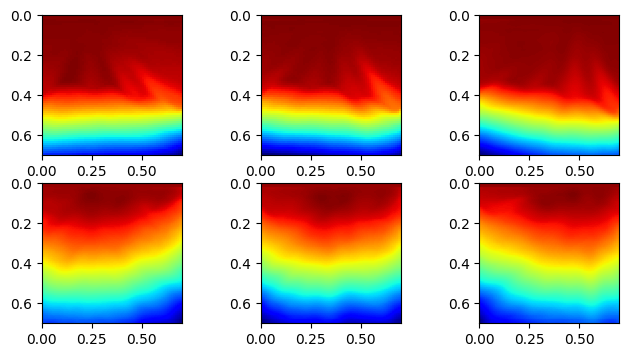

epoch: 310 MSE loss: 442.2273864746094 Accuracy(%): 85.57425856590271


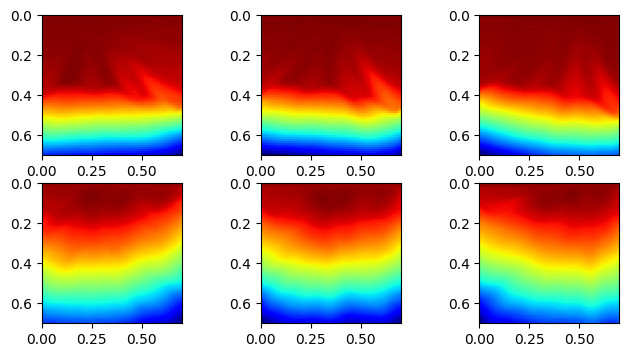

epoch: 320 MSE loss: 434.1986999511719 Accuracy(%): 84.97013926506042


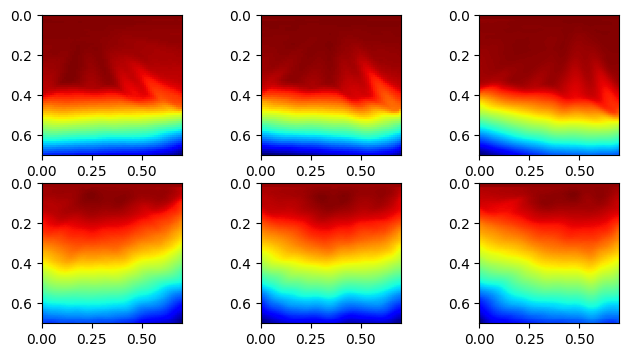

epoch: 330 MSE loss: 415.2025146484375 Accuracy(%): 85.29684662818909


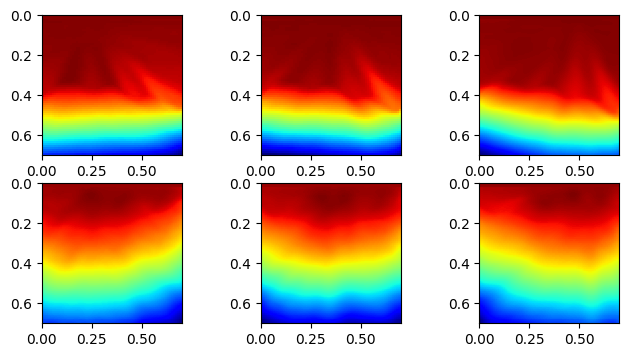

epoch: 340 MSE loss: 400.8350830078125 Accuracy(%): 85.7671856880188


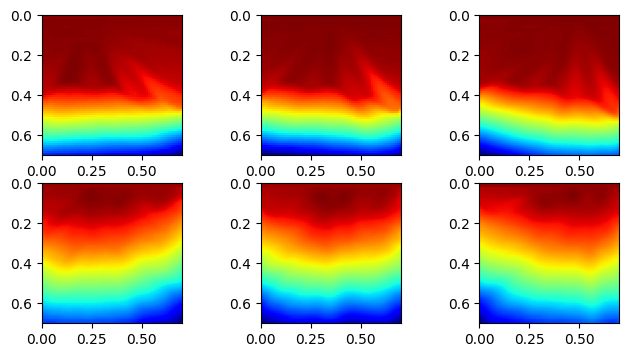

epoch: 350 MSE loss: 405.73956298828125 Accuracy(%): 86.40473365783691


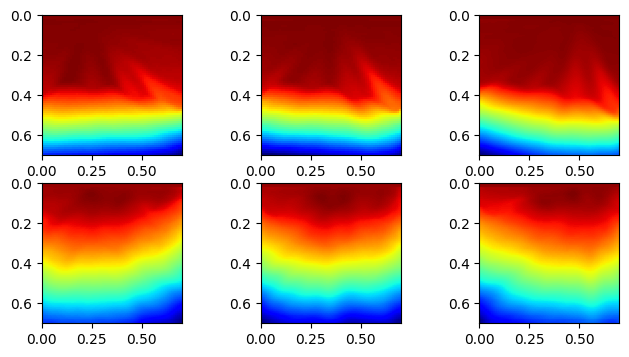

epoch: 360 MSE loss: 416.87744140625 Accuracy(%): 86.39285802841187


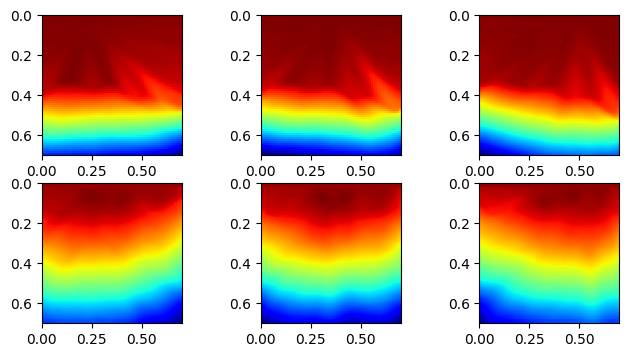

epoch: 370 MSE loss: 370.04254150390625 Accuracy(%): 86.52099609375


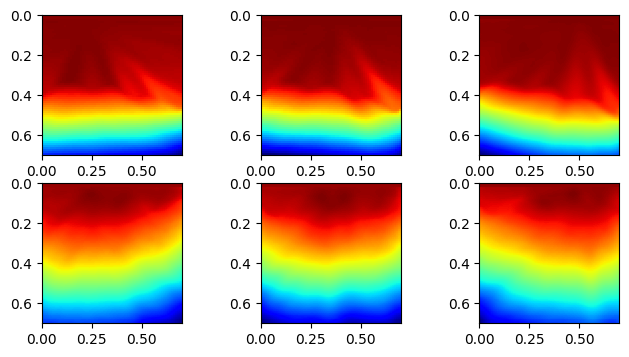

epoch: 380 MSE loss: 363.3780212402344 Accuracy(%): 86.11140012741089


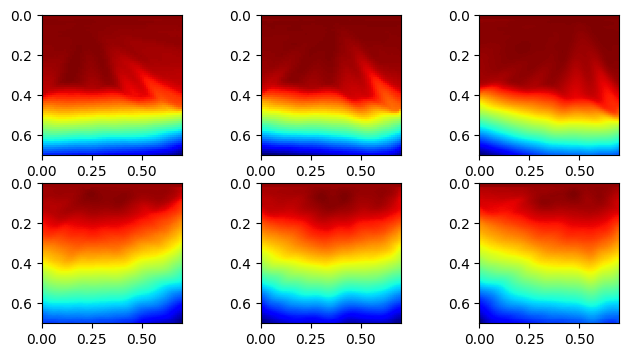

epoch: 390 MSE loss: 390.95684814453125 Accuracy(%): 86.0041093826294


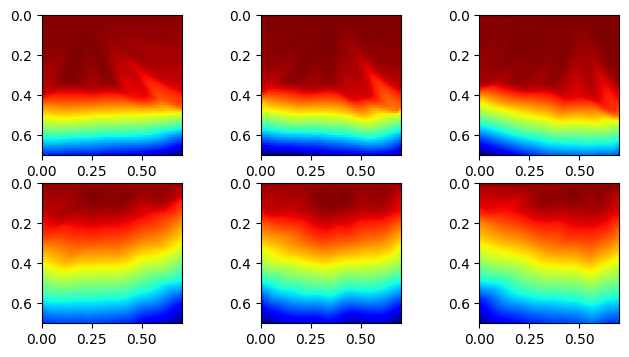

epoch: 400 MSE loss: 342.2294921875 Accuracy(%): 86.64185881614685


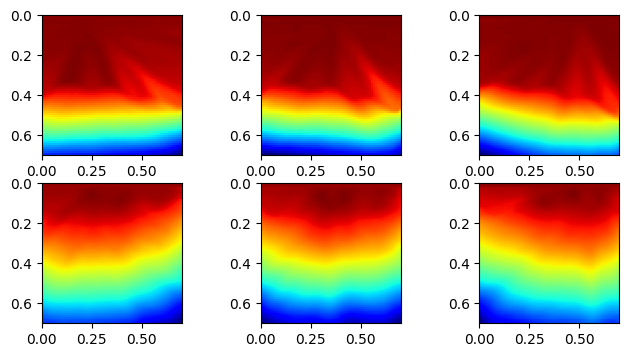

epoch: 410 MSE loss: 342.24871826171875 Accuracy(%): 87.11574792861938


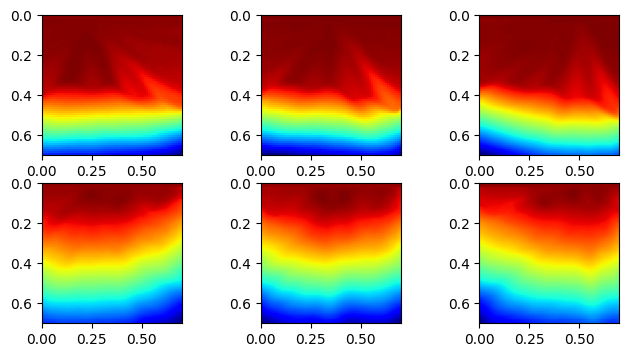

epoch: 420 MSE loss: 371.18902587890625 Accuracy(%): 87.23736643791199


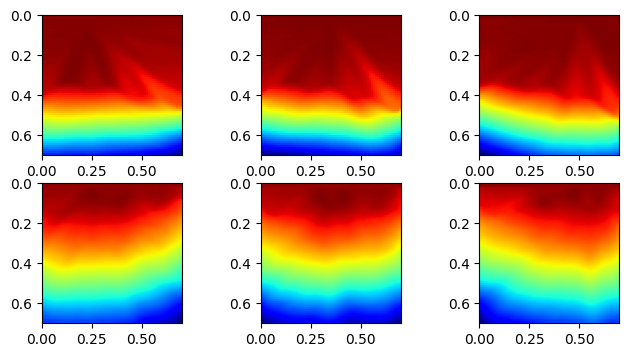

epoch: 430 MSE loss: 343.16839599609375 Accuracy(%): 87.22217202186584


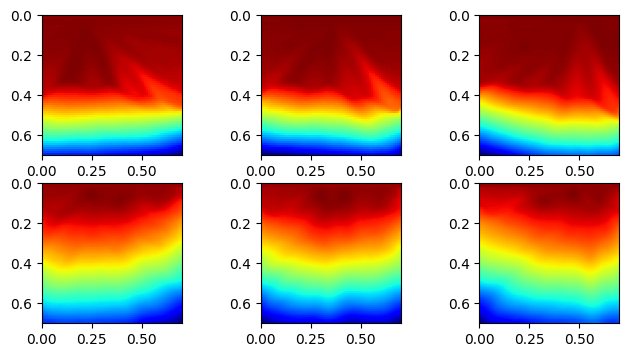

epoch: 440 MSE loss: 326.4815673828125 Accuracy(%): 87.25688219070435


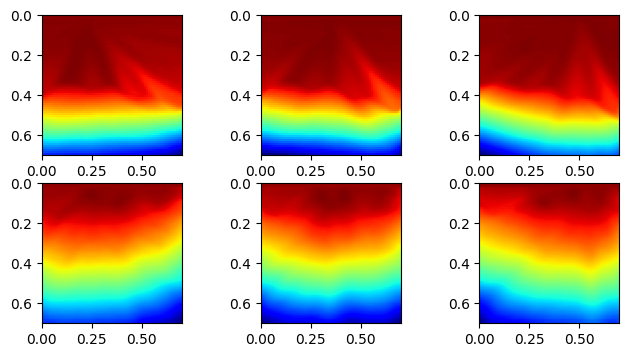

epoch: 450 MSE loss: 338.12841796875 Accuracy(%): 87.2011923789978


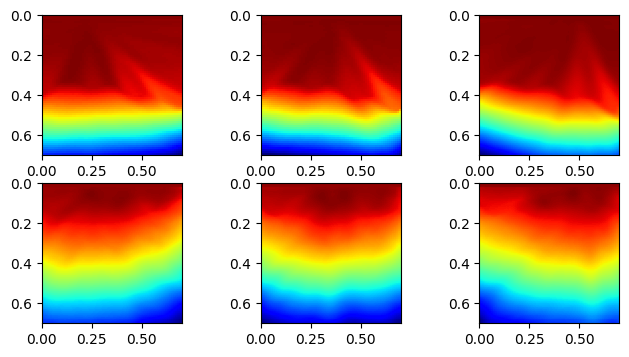

epoch: 460 MSE loss: 295.81195068359375 Accuracy(%): 87.32627630233765


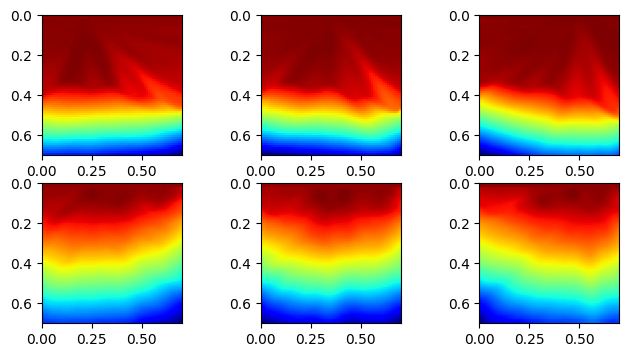

epoch: 470 MSE loss: 314.9109191894531 Accuracy(%): 87.42285966873169


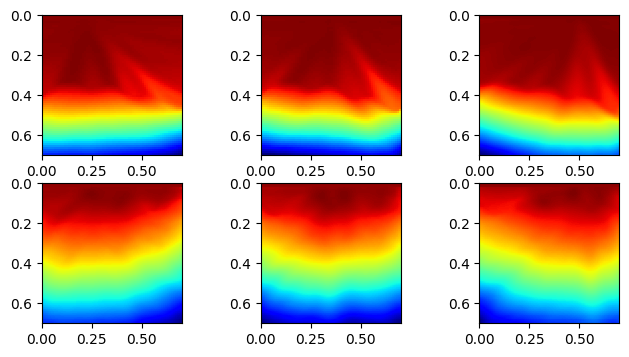

epoch: 480 MSE loss: 294.25640869140625 Accuracy(%): 87.45749831199646


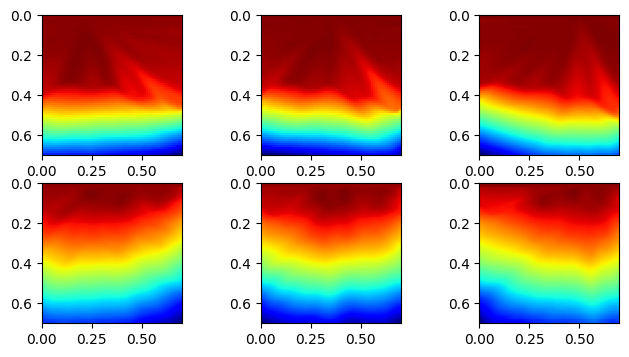

epoch: 490 MSE loss: 296.2008361816406 Accuracy(%): 87.40939259529114


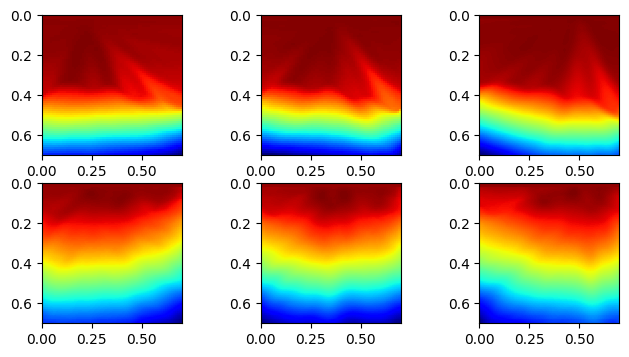

epoch: 500 MSE loss: 275.9911193847656 Accuracy(%): 87.43460416793823


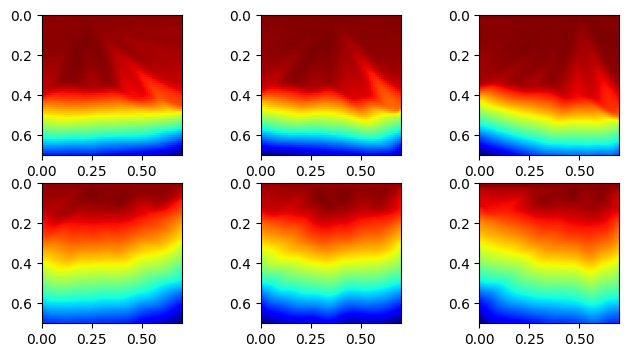

epoch: 510 MSE loss: 296.42596435546875 Accuracy(%): 87.55926489830017


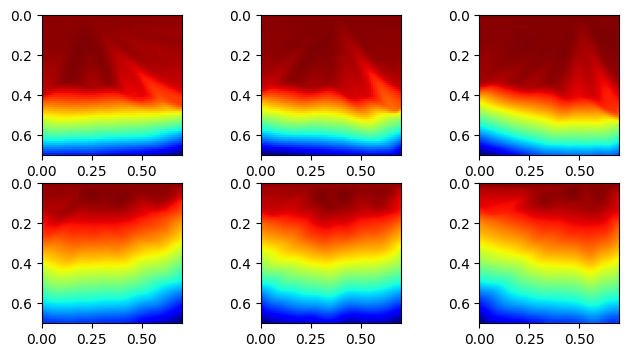

In [ ]:
##################################################
########### training and evaluation###############
##################################################
for ep in range(epochs):
    model.train()
    t1 = time.time()
    train_mse = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        tau, loss = model(x, y)
        #mse = torch.sum(torch.pow(loss[:,:,1:-1,1:-1],2)) + 0.0001*torch.sum(torch.pow(tau[:,:,1:-1,1:-1],2))
        mse = torch.sum(torch.pow(loss[:,:,1:-1,1:-1],2)) 
        mse.backward()

        optimizer.step()
        train_mse += mse.item()

    scheduler.step()
    model.eval()

    train_mse /= len(train_loader)
    
    t2 = time.time()    
    mse_train.append(train_mse)
    
    for x1, y1, z1 in test_loader:
        x1, y1, z1 = x1.cuda(), y1.cuda(), z1.cuda()
        test_l2 = 0
        base = 0
        out1,_ = model(x1, y1)
        test_l2 += myloss(torch.abs(out1.reshape(ns, -1)), torch.abs(z1.reshape(ns, -1))).item() 
        base += myloss(out1.reshape(ns, -1)*0, torch.abs(z1.reshape(ns, -1))).item() 

    accuracy = (1.0-test_l2/base)*100
    l2_test.append(accuracy)
    
    if (ep % 10 == 0):
        #torch.save(model, path_model+'_epoch%(d)'%(ep))
        torch.save(model, path_model)
        print('epoch:',ep, 'MSE loss:',train_mse, 'Accuracy(%):', accuracy)
       
        plt.figure(figsize=(8,4))
        plt.subplot(2,3,1)
        ax = plt.gca()
        im = ax.imshow(out1[0,3,:,:].cpu().detach().numpy(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
        plt.subplot(2,3,2)
        ax = plt.gca()
        im = ax.imshow(out1[0,5,:,:].cpu().detach().numpy(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
        plt.subplot(2,3,3)
        ax = plt.gca()
        im = ax.imshow(out1[0,7,:,:].cpu().detach().numpy(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
        plt.subplot(2,3,4)
        ax = plt.gca()
        im = ax.imshow(out1[1,3,:,:].cpu().detach().numpy(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
        plt.subplot(2,3,5)
        ax = plt.gca()
        im = ax.imshow(out1[1,5,:,:].cpu().detach().numpy(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
        plt.subplot(2,3,6)
        ax = plt.gca()
        im = ax.imshow(out1[1,7,:,:].cpu().detach().numpy(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
        plt.show()

In [ ]:
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_T0, train_right, train_tau), batch_size=1, shuffle=False)
pred = torch.zeros(train_tau.shape)
index = 0
t1 = time.time()
with torch.no_grad():
    for x, y, z in test_loader:
        test_l2 = 0
        x, y, z = x.cuda(), y.cuda(), z.cuda()
        out,_ = model(x,y)
        pred[index] = out
        test_l2 += myloss(out.reshape(1, -1), z.reshape(1, -1)).item()
        index = index + 1
t2 = time.time()
print('PIFNO prediction time:', t2-t1)

In [ ]:
N = epochs
plt.figure(figsize=(6,4))
#plt.subplot(1,2,1)
plt.plot(mse_train)
plt.yscale('log')
plt.xlabel("Epoch", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Loss", fontsize=12)
plt.yticks(fontsize=10)
plt.savefig('./Fig/Loss_curve.jpeg',dpi=400)

plt.figure(figsize=(6,4))
plt.plot(l2_test[:-10])
# plt.yscale('log')
plt.xlabel("Epoch", fontsize=12)
plt.xticks(fontsize=10)
plt.ylim([0, 100])
plt.ylabel("Accuracy (%)", fontsize=12)
plt.yticks(fontsize=10)
plt.savefig('./Fig/Accuracy_curve.jpeg',dpi=400)
#plt.savefig('./Fig/Loss_layer.jpeg',dpi=400)

In [ ]:
isou = 5

iv1 = 46
iv2 = 25
iv3 = 27

plt.style.use('default')

plt.figure(figsize=(20,12))

plt.subplot(3,4,1)
ax = plt.gca()
im = ax.imshow(train_vel[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,2)
ax = plt.gca()
im = ax.imshow(train_tau[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,3)
ax = plt.gca()
im = ax.imshow(pred[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,4)
ax = plt.gca()
im = ax.imshow(train_tau[iv1,isou,:,:].cpu()-pred[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,5)
ax = plt.gca()
im = ax.imshow(train_vel[iv2,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,6)
ax = plt.gca()
im = ax.imshow(train_tau[iv2,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,7)
ax = plt.gca()
im = ax.imshow(pred[iv2,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,8)
ax = plt.gca()
im = ax.imshow(train_tau[iv2,isou,:,:].cpu()-pred[iv2,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,9)
ax = plt.gca()
im = ax.imshow(train_vel[iv3,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,10)
ax = plt.gca()
im = ax.imshow(train_tau[iv3,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,11)
ax = plt.gca()
im = ax.imshow(pred[iv3,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)
                           
plt.subplot(3,4,12)
ax = plt.gca()
im = ax.imshow(train_tau[iv3,isou,:,:].cpu()-pred[iv3,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)
#plt.savefig('./Fig/layer50_train_tau1_isou5.jpeg',dpi=400)

In [ ]:
T_data_pred = pred.cuda() + train_T0_data.cuda()

plt.style.use('default')
plt.figure(figsize=(20,12))
plt.subplot(3,4,1)
ax = plt.gca()
im = ax.imshow(train_vel[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,2)
ax = plt.gca()
im = ax.imshow(train_T_data[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,3)
ax = plt.gca()
im = ax.imshow(T_data_pred[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,4)
ax = plt.gca()
im = ax.imshow(T_data_pred[iv1,isou,:,:].cpu()-train_T_data[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,5)
ax = plt.gca()
im = ax.imshow(train_vel[iv2,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=10)
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,6)
ax = plt.gca()
im = ax.imshow(train_T_data[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,7)
ax = plt.gca()
im = ax.imshow(T_data_pred[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,8)
ax = plt.gca()
im = ax.imshow(T_data_pred[iv2,isou,:,:].cpu()-train_T_data[iv2,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,9)
ax = plt.gca()
im = ax.imshow(train_vel[iv3,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=10)
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,10)
ax = plt.gca()
im = ax.imshow(train_T_data[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,11)
ax = plt.gca()
im = ax.imshow(T_data_pred[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,12)
ax = plt.gca()
im = ax.imshow(T_data_pred[iv3,isou,:,:].cpu()-train_T_data[iv3,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)
#plt.savefig('./Fig/layer50_train_T_isou3.jpeg',dpi=400)

In [ ]:
test_vel = []
test_T_data = []
test_T0_data = []
# Loading the velocity model
#vel1 = np.load('./inputs/seam_model/vel_seam.npy')
for i in range(51, 61):
   
    vel = np.load('./Model/model1/model_%d.npy'%(i)) 
    vel[0:5,:] = 1.5 
    vels = gaussian_filter(vel, sigma=1)
    
    T0 = np.load('./Model/model1/T0_data%d.npy'%(i))
    T = np.load('./Model/model1/T_data%d.npy'%(i))
    test_vel.append(vels)
    test_T0_data.append(T0)
    test_T_data.append(T)

test_T_data = torch.Tensor(np.array(test_T_data)).permute(0,3,1,2)
test_T0_data = torch.Tensor(np.array(test_T0_data)).permute(0,3,1,2)
test_tau = test_T_data - test_T0_data
nv, ns, nz, nx = test_T_data.shape[0], test_T_data.shape[1], test_T_data.shape[2], test_T_data.shape[3]
test_vel = torch.Tensor(np.array(test_vel)).repeat(ns,1,1,1).permute(1,0,2,3)
test_right = 1/test_vel/test_vel
test_T0 =  torch.cat((test_right.view(nv, ns, nz, nx, 1).repeat([1,1,1,1,ns]), test_T0_data.view(nv, ns, nz, nx, 1).repeat([1,1,1,1,ns])), dim=-1)


batch_size = nv
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_T0, test_right), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_T0, test_right, test_tau), batch_size=batch_size, shuffle=False)

##prediction for test data
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_T0, test_right, test_tau), batch_size=1, shuffle=False)
pred_test = torch.zeros(test_tau.shape)
index = 0
t1 = time.time()
with torch.no_grad():
    for x, y, z in test_loader:
        test_l2 = 0
        x, y, z = x.cuda(), y.cuda(), z.cuda()
        out,_ = model(x,y)
        pred_test[index] = out

        test_l2 += myloss(out.reshape(1, -1), z.reshape(1, -1)).item()
        l2_test.append(test_l2)
        print("Test loss:", index,test_l2)
        index = index + 1

t2 = time.time()
print('PIFNO prediction time:', t2-t1)
#scipy.io.savemat('pred_test_fno3d_curvelet10.mat', mdict={'u_pred_test': pred_test.cpu().numpy()})

In [ ]:
isou = 5
iv1 = 1
iv2 = 2
iv3 = 6
plt.style.use('default')

plt.figure(figsize=(20,12))
plt.subplot(3,4,1)
ax = plt.gca()
im = ax.imshow(test_vel[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,2)
ax = plt.gca()
im = ax.imshow(test_tau[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,3)
ax = plt.gca()
im = ax.imshow(pred_test[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,4)
ax = plt.gca()
im = ax.imshow(test_tau[iv1,isou,:,:].cpu()-pred_test[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,5)
ax = plt.gca()
im = ax.imshow(test_vel[iv2,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,6)
ax = plt.gca()
im = ax.imshow(test_tau[iv2,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,7)
ax = plt.gca()
im = ax.imshow(pred_test[iv2,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,8)
ax = plt.gca()
im = ax.imshow(test_tau[iv2,isou,:,:].cpu()-pred_test[iv2,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,9)
ax = plt.gca()
im = ax.imshow(test_vel[iv3,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,10)
ax = plt.gca()
im = ax.imshow(test_tau[iv3,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,11)
ax = plt.gca()
im = ax.imshow(pred_test[iv3,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,12)
ax = plt.gca()
im = ax.imshow(test_tau[iv3,isou,:,:].cpu()-pred_test[iv3,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)
#plt.savefig('./Fig/layer10_test_tau.jpeg',dpi=400)
#plt.savefig('./Fig/layer_train_curvelet_test_tau.jpeg',dpi=400)

In [ ]:
T_data_pred = pred_test.cuda() + test_T0_data.cuda()
plt.style.use('default')

plt.figure(figsize=(20,12))
plt.subplot(3,4,1)
ax = plt.gca()
im = ax.imshow(test_vel[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,2)
ax = plt.gca()
im = ax.imshow(test_T_data[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,3)
ax = plt.gca()
im = ax.imshow(T_data_pred[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,4)
ax = plt.gca()
im = ax.imshow(T_data_pred[iv1,isou,:,:].cpu()-test_T_data[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,5)
ax = plt.gca()
im = ax.imshow(test_vel[iv2,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,6)
ax = plt.gca()
im = ax.imshow(test_T_data[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,7)
ax = plt.gca()
im = ax.imshow(T_data_pred[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,8)
ax = plt.gca()
im = ax.imshow(T_data_pred[iv2,isou,:,:].cpu()-test_T_data[iv2,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,9)
ax = plt.gca()
im = ax.imshow(test_vel[iv3,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,10)
ax = plt.gca()
im = ax.imshow(test_T_data[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,11)
ax = plt.gca()
im = ax.imshow(T_data_pred[iv1,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)

plt.subplot(3,4,12)
ax = plt.gca()
im = ax.imshow(T_data_pred[iv3,isou,:,:].cpu()-test_T_data[iv3,isou,:,:].cpu(), extent=[xmin,xmax,zmax,zmin],  aspect=1, cmap="jet")
plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)
#plt.savefig('./Fig/curvelet10_test_T.jpeg',dpi=400)
#plt.savefig('./Fig/curvelet_train_model6_test_T.jpeg',dpi=400)